# Классификация с использование sklearn

## Импорт библиотек

In [173]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Подготовка данных

In [18]:
path_to_file = '../datasets/classification/occupancy_detection_preprocessed.csv'
dataset = pd.read_csv(path_to_file)

In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     20560 non-null  int64  
 1   date           20560 non-null  object 
 2   Temperature    20560 non-null  float64
 3   Humidity       20560 non-null  float64
 4   Light          20560 non-null  float64
 5   CO2            20560 non-null  float64
 6   HumidityRatio  20560 non-null  float64
 7   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 1.3+ MB


Удалим из датасета признаки *Unnamed: 0* (индекс объекта) и *date*, так как они не нужны для классификации

In [20]:
dataset = dataset.drop(['Unnamed: 0', 'date'], axis=1)

In [21]:
dataset.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.7000,26.272,585.200000,749.200000,0.004764,1
1,23.7180,26.290,578.400000,760.400000,0.004773,1
2,23.7300,26.230,572.666667,769.666667,0.004765,1
3,23.7225,26.125,493.750000,774.750000,0.004744,1
4,23.7540,26.200,488.600000,779.000000,0.004767,1


Разобъём данные на признаки и целевую переменную

In [16]:
dataset.Occupancy.value_counts()

0    15810
1     4750
Name: Occupancy, dtype: int64

In [23]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 5].values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [28]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Классификация с ручным подбором гиперпараметров

In [55]:
def get_mean_error_rate(clf):
    skf = StratifiedKFold(n_splits=5)
    scores = []
    for train_index, test_index in skf.split(X, y):        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        
        scores.append(1.0 - clf.score(X_test, y_test))
        
    return np.mean(scores)

In [95]:
def plot_error_param_dep(params, errors, title, xlabel, ylabel='Средняя ошибка'):
    plt.figure(figsize=(12, 6))
    plt.plot(params, errors, color='green', linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

### k-ближайших соседей 

Используя кросс-валидацию на 5 фолдов, подберём гиперпараметр k -- количество соседей. Выберем то значение k, на котором средняя ошибка на кросс-валидации наименьшая

In [56]:
%%time
errors = []
n_neighbors = list(range(1, 16))

for k in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    error = get_mean_error_rate(knn)
    errors.append(error)

Wall time: 15 s


Для наглядности отобразим график зависимости ошибки от количеста соседей

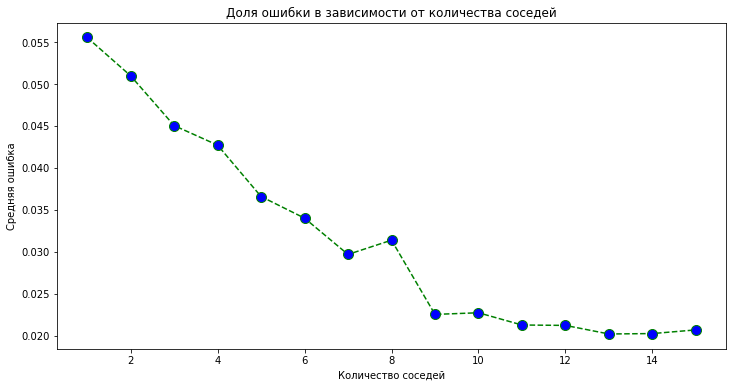

In [65]:
plot_error_param_dep(n_neighbors, errors, 'Доля ошибки в зависимости от количества соседей',
                     'Количество соседей', 'Средняя ошибка')

In [59]:
min_error = np.min(errors)
k_min_error = errors.index(min_error) + 1
print('Наименьшая ошибка {:.3f} для k = {}'.format(min_error, k_min_error))

Наименьшая ошибка 0.020 для k = 13


Таким образом, оптимально будет использовать **k = 13**. В таком случае ошибка будет составлять **0.020**

### Дерево решений

Используя кросс-валидацию на 5 фолдов, подберём гиперпараметр max_depth -- максимальная глубина дерева. Выберем то значение max_depth, на котором средняя ошибка на кросс-валидации наименьшая

In [81]:
%%time
errors = []
depths = list(range(1, 21))

for depth in depths:
    dtc = DecisionTreeClassifier(max_depth=depth)
    error = get_mean_error_rate(dtc)
    errors.append(error)

Wall time: 2.92 s


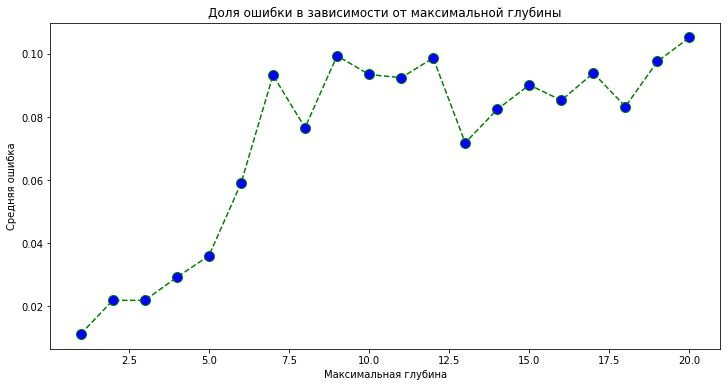

In [82]:
plot_error_param_dep(depths, errors, 'Доля ошибки в зависимости от максимальной глубины',
                     'Максимальная глубина', 'Средняя ошибка')

Посчитаем ошибку на классификаторе с дефолтными значениями параметров

In [83]:
default_dtc = DecisionTreeClassifier()
error = get_mean_error_rate(default_dtc)
error

0.08477626459143968

In [84]:
min_error = np.min(errors)
md_min_error = errors.index(min_error) + 1
print('Наименьшая ошибка {:.3f} для max_depth = {}'.format(min_error, md_min_error))

Наименьшая ошибка 0.011 для max_depth = 1


Таким образом, оптимально будет использовать max_depth = 1. В таком случае ошибка будет составлять 0.011   
***Мне кажется, здесь есть какая-то ошибка, но я её не понимаю :(***

### Наивный байесовский классификатор

Подберём распределение, на котором будет наименьшая ошибка

In [102]:
%%time
errors = []
nbs = [GaussianNB(), MultinomialNB(), BernoulliNB(), ComplementNB()]
for nb in nbs:
    error = get_mean_error_rate(nb)
    errors.append(error)

Wall time: 86.3 ms


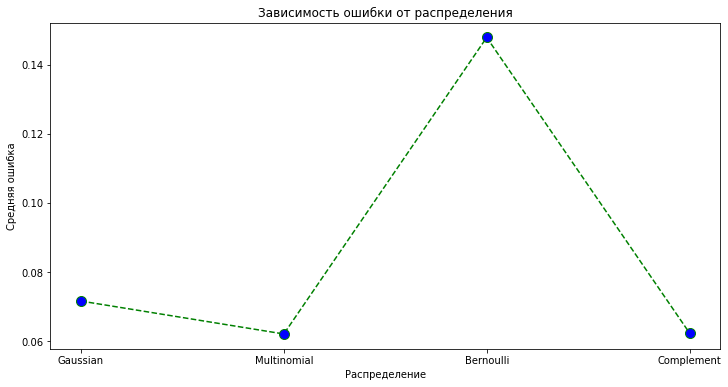

In [111]:
distributions = ['Gaussian', 'Multinominal', 'Bernoulli', 'Complement']
plot_error_param_dep(distributions, errors,
                     'Зависимость ошибки от распределения', 'Распределение')

In [112]:
min_error = np.min(errors)
nb_min_error = distributions[errors.index(min_error)]
print('Наименьшая ошибка {:.3f} для распределения {}'.format(min_error, nb_min_error))

Наименьшая ошибка 0.062 для распределения Multinomial


Таким образом, оптимально будет использовать **MultinominalNB()**

### Метод опорных векторов

Подберём значение гиперпараметра kernel -- ядра, используемого в методе

In [115]:
%%time
errors = []
kernels = ['linear', 'poly', 'rbf']
for kernel in kernels:
    svc = SVC(kernel=kernel)
    error = get_mean_error_rate(svc)
    errors.append(error)

Wall time: 5min 58s


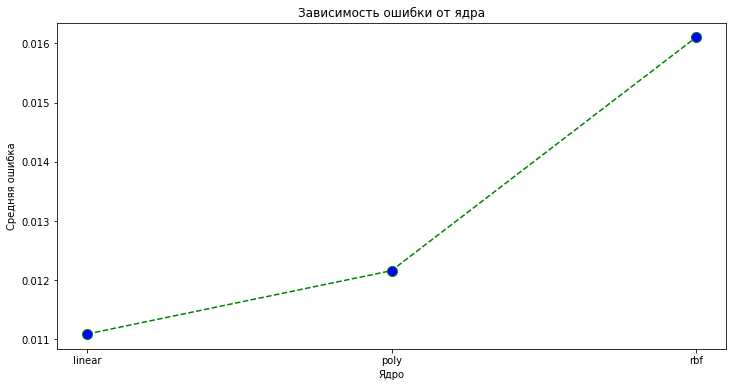

In [116]:
plot_error_param_dep(kernels, errors, 'Зависимость ошибки от ядра', 'Ядро')

In [118]:
min_error = np.min(errors)
kernel_min_error = kernels[errors.index(min_error)]
print('Наименьшая ошибка {:.3f} для kernel = {}'.format(min_error, kernel_min_error))

Наименьшая ошибка 0.011 для kernel = linear


Таким образом, оптимально будет использовать **kernel = linear** 

### Логистическая регрессия

Подберём параметр penalty -- вид регуляризации

In [122]:
%%time
errors = []
penaltys = ['l2', 'none']

for penalty in penaltys:
    lr = LogisticRegression(penalty=penalty)
    error = get_mean_error_rate(lr)
    errors.append(error)

Wall time: 595 ms


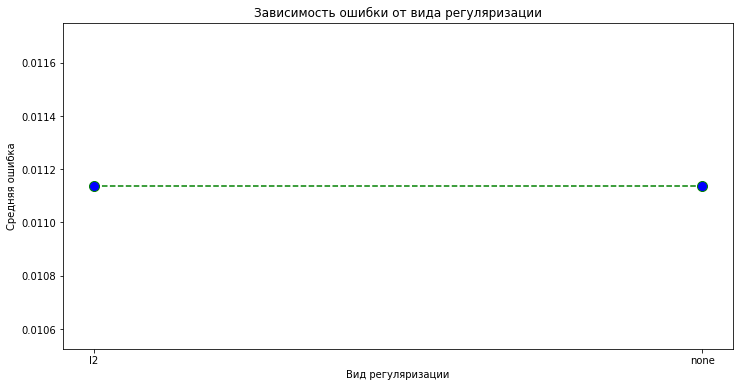

In [123]:
plot_error_param_dep(penaltys, errors, 'Зависимость ошибки от вида регуляризации', 'Вид регуляризации')

In [125]:
print('{:.3f}'.format(np.min(errors)))

0.011


Исходя из графика, можно использовать дефолтную **L2-регуляризацию** с долей ошибки **0.011**

## Классификация с использованием GridSearch

### Подготовка данных

In [128]:
path_to_file = '../datasets/classification/occupancy_detection_preprocessed.csv'
dataset = pd.read_csv(path_to_file)

dataset = dataset.drop(['Unnamed: 0', 'date'], axis=1)

X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 5].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [160]:
def get_best_est_params(estimator, params):
    clf = GridSearchCV(estimator, params)
    clf.fit(X_train, y_train)
    return clf.best_params_

In [154]:
def pretty_print(params):
    for key, value in params.items():
        print(f'{key}: {value}')

### k-ближайших соседей

In [150]:
%%time

params = {
    'n_neighbors': list(range(1, 11)),
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

best_knn_params = get_best_est_params(KNeighborsClassifier(), params)

Wall time: 24.1 s


In [155]:
pretty_print(best_knn_params)

metric: euclidean
n_neighbors: 5


### Дерево решений

In [161]:
%%time

params = {
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': list(range(5, 11))
}

best_tree_params = get_best_est_params(DecisionTreeClassifier(), params)

Wall time: 1.97 s


In [162]:
pretty_print(best_tree_params)

max_depth: 10
max_features: sqrt


### Наивный Байес 

Я не нашёл, какие параметры можно подобрать через grid search, потому что в большинстве случаев не понимаю их назначение

### Метод опорных векторов

In [176]:
%%time

params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto']
}

best_svc_params = get_best_est_params(SVC(), params)

Wall time: 14.2 s


In [177]:
pretty_print(best_svc_params)

gamma: scale
kernel: rbf


### Логистическая регрессия

In [174]:
%%time

params = {
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet', 'none']
}

best_lr_params = get_best_est_params(LogisticRegression(), params)

Wall time: 3.32 s


In [175]:
pretty_print(best_lr_params)

penalty: l1
solver: liblinear
